In [9]:
%%capture

# By these two lines, it will not be needed to restart kernel when applying change in a library
%load_ext autoreload
%autoreload 2

# import main
import dolfin  
import numpy    as np
import sympy    as sp
import matplotlib.pyplot as plt
from sympy.plotting import plot
import math
import pickle
from numpy import linspace
from sympy import lambdify
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from matplotlib.collections import PatchCollection
import sys

import myPythonLibrary as mypy
import dolfin_mech     as dmech
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

from scipy.optimize import minimize
from scipy.optimize import fsolve

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import seeds
import geometry


# Defining Geometry and material parameters

In [10]:
%%capture
fname = "Geometries/Hexagon/hexagon_RVE1"

domain = 1
row = 1
DoI = 0.0
thickness = 0.092
shift_y = 0

seeds.semi_regular(DoI, row, domain)
geometry.voronoi(fname, thickness, row, domain, shift_y, seeds_remove=True)

mesh = dolfin.Mesh()
dolfin.XDMFFile(fname+"-mesh.xdmf").read(mesh)
Es = 1
nus = 0.499
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])
vol = (xmax - xmin)*(ymax - ymin)
dV = dolfin.Measure("dx",domain=mesh)
Phi_s0 = dolfin.assemble(1*dV)/vol

vertices = np.array([[xmin, ymin],
                     [xmax, ymin],
                     [xmax, ymax],
                     [xmin, ymax]])
bbox = [xmin, xmax, ymin, ymax]

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 152 (Line)
Info    : [ 20%] Meshing curve 153 (Line)
Info    : [ 20%] Meshing curve 154 (Line)
Info    : [ 30%] Meshing curve 155 (Line)
Info    : [ 30%] Meshing curve 156 (Line)
Info    : [ 30%] Meshing curve 157 (Line)
Info    : [ 40%] Meshing curve 158 (Line)
Info    : [ 40%] Meshing curve 159 (Line)
Info    : [ 40%] Meshing curve 160 (Line)
Info    : [ 50%] Meshing curve 161 (Line)
Info    : [ 50%] Meshing curve 162 (Line)
Info    : [ 50%] Meshing curve 163 (Line)
Info    : [ 60%] Meshing curve 164 (Line)
Info    : [ 60%] Meshing curve 165 (Line)
Info    : [ 70%] Meshing curve 166 (Line)
Info    : [ 70%] Meshing curve 167 (Line)
Info    : [ 70%] Meshing curve 168 (Line)
Info    : [ 80%] Meshing curve 169 (Line)
Info  

# Kinematics

In [11]:

alpha_x, alpha_y, alpha_xy, alpha_yx = sp.symbols('alpha_x alpha_y alpha_xy alpha_yx')
epsilon_x = sp.symbols('epsilon_x')
epsilon_y = sp.symbols('epsilon_y')
epsilon_xy = sp.symbols('epsilon_xy')
epsilon = sp.symbols('epsilon')
C_CM = sp.MatrixSymbol('C', 2, 2).as_explicit()

C00, C01, C10, C11 = sp.symbols('C00 C01 C10 C11')
C_CM = sp.Matrix([[C00, C01],
                  [C10, C11]])


p = sp.symbols('p')
I_C_CM   = sp.trace(C_CM) 
II_C_CM  = (sp.trace(C_CM)**2 - sp.trace(C_CM**2))/2 
III_C_CM = sp.det(C_CM) 
J_CM     = sp.sqrt(III_C_CM)
E_CM = (C_CM - sp.eye(2))/2 

C_CM_bar = J_CM**(-2/3)*C_CM
I_C_CM_bar   = sp.trace(C_CM_bar) 
II_C_CM_bar  = (sp.trace(C_CM_bar)**2 - sp.trace(C_CM_bar**2))/2 


F = sp.Matrix(
        [[alpha_x,    0  ],\
        [   0   , alpha_y]])

J = F.det()
C = F.T * F
E = (C - sp.eye(2))/2 

# Macroscopic model

In [12]:
def macroscopic_model(mat_params):
    homo = dmech.HomogenizationProblem(
        dim=2,
        mesh=mesh,
        mat_params=mat_params["parameters"],
        vertices=vertices,
        vol=vol,
        bbox=bbox)

    lmbda, mu = homo.get_lambda_and_mu()
    beta = mu/2
    alpha = lmbda/4


    W_skel = beta * (I_C_CM - 2 - 2 * sp.ln(J_CM)) + alpha * (J_CM**2 - 1 - 2 * sp.ln(J_CM)) 
    Sigma_CM = 2*sp.diff(W_skel, C_CM) - p * J_CM * C_CM.inv()

    Sigma = Sigma_CM.subs(list(zip(C_CM, C))).doit().as_explicit() 
    sigma = F * Sigma * F.T / J 
    sigma = sigma.subs(alpha_x, epsilon + 1).subs(alpha_y, epsilon + 1)
    # sigma = sigma.subs(alpha_x, sp.sqrt(2*epsilon + 1)).subs(alpha_y, sp.sqrt(2*epsilon + 1))


    Ter_Sigma = 2*sp.diff(W_skel, C_CM)      
    Ter_Sigma = Ter_Sigma.subs(list(zip(C_CM, C))).doit().as_explicit() 
    Ter_Sigma = Ter_Sigma.subs(alpha_x, epsilon + 1).subs(alpha_y, epsilon + 1)
    # Ter_Sigma = Ter_Sigma.subs(alpha_x, sp.sqrt(2*epsilon + 1)).subs(alpha_y, sp.sqrt(2*epsilon + 1))

    return sigma, Ter_Sigma

# Linear model

In [13]:
homo = dmech.HomogenizationProblem(dim=2,
                mesh=mesh,
                mat_params=mat_params["parameters"],
                vertices=vertices,
                vol=vol,
                bbox=bbox)
lmbda_tilde, mu_tilde = homo.get_lambda_and_mu()
kappa_tilde = homo.get_kappa()
beta = mu_tilde/2
alpha = lmbda_tilde/4

sigma_lin =  2 * lmbda_tilde * epsilon + 2 * mu_tilde * epsilon
sigma_macro, sigma_ter_macro = macroscopic_model(mat_params)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


## Global response of the micromechanical model is a function of:
* material parameters
* $\epsilon_{xx}, \epsilon_{yy}$ $\longrightarrow$ macroscopic strain
* If no macroscopic strain is applied, `Macroscopic_strain` = <span style="color:lightblue">None</span>
* sigma_bar is the applied stress, otherwise:
\begin{equation}
    \sigma = \begin{bmatrix}
                0 & 0\\
                0 & 0
             \end{bmatrix}
\end{equation}

<!-- * $\gamma$ is the surface tension coefficient, otherwise it is equal to zero -->

In [14]:
def global_response(mesh, mat_params, eps_xx, eps_yy, pf, Macroscopic_strain, sigma_bar, gamma):


    dim = 2
    bcs = "pbc"
    step_params = {"dt_ini":1e-1, "dt_min":1e-3}


    res_folder = sys.argv[0][:-3]
    res_basename  = sys.argv[0][:-3]

    res_basename = res_folder+"/"+res_basename
    verbose=1

    ################################################################### Mesh ###


    coord = mesh.coordinates()
    xmax = max(coord[:,0]); xmin = min(coord[:,0])
    ymax = max(coord[:,1]); ymin = min(coord[:,1])
    vol = (xmax - xmin)*(ymax - ymin)
    dV = dolfin.Measure("dx",domain=mesh)

    vertices = np.array([[xmin, ymin],
                         [xmax, ymin],
                         [xmax, ymax],
                         [xmin, ymax]])

    tol = 1E-8  
    vv = vertices
    a1 = vv[1,:]-vv[0,:] # first vector generating periodicity
    a2 = vv[3,:]-vv[0,:] # second vector generating periodicity
    # check if UC vertices form indeed a parallelogram
    assert np.linalg.norm(vv[2, :]-vv[3, :] - a1) <= tol
    assert np.linalg.norm(vv[2, :]-vv[1, :] - a2) <= tol
    bbox = [xmin, xmax, ymin, ymax]

    ################################################## Subdomains & Measures ###

    
    xmin_sd = dolfin.CompiledSubDomain("near(x[0], x0, tol) && on_boundary", x0=xmin, tol=tol)
    xmax_sd = dolfin.CompiledSubDomain("near(x[0], x0, tol) && on_boundary", x0=xmax, tol=tol)
    ymin_sd = dolfin.CompiledSubDomain("near(x[1], x0, tol) && on_boundary", x0=ymin, tol=tol)
    ymax_sd = dolfin.CompiledSubDomain("near(x[1], x0, tol) && on_boundary", x0=ymax, tol=tol)
    if (dim==3): zmin_sd = dolfin.CompiledSubDomain("near(x[2], x0, tol) && on_boundary", x0=zmin, tol=tol)
    if (dim==3): zmax_sd = dolfin.CompiledSubDomain("near(x[2], x0, tol) && on_boundary", x0=zmax, tol=tol)


    xmin_id = 1
    xmax_id = 2
    ymin_id = 3
    ymax_id = 4
    if (dim==3): zmin_id = 5
    if (dim==3): zmax_id = 6

    boundaries_mf = dolfin.MeshFunction("size_t", mesh, mesh.topology().dim()-1) # MG20180418: size_t looks like unisgned int, but more robust wrt architecture and os
    boundaries_mf.set_all(0)

    ################################################################ Problem ###

    problem = dmech.MicroPoroHyperelasticityProblem(
        mesh=mesh,
        mesh_bbox=bbox,
        vertices=vertices,
        boundaries_mf=boundaries_mf,
        displacement_perturbation_degree=2,
        quadrature_degree=3,
        solid_behavior=mat_params,
        bcs=bcs)

    ################################################################ Loading ###

    Deltat = step_params.get("Deltat", 1.)
    dt_ini = step_params.get("dt_ini", 1.)
    dt_min = step_params.get("dt_min", 1.)
    dt_max = step_params.get("dt_max", 1.)
    k_step = problem.add_step(
        Deltat=Deltat,
        dt_ini=dt_ini,
        dt_min=dt_min,
        dt_max=dt_max)


    problem.add_surface_pressure_loading_operator(
        measure=problem.dS(0),
        P_ini=0., P_fin=pf,
        k_step=k_step)

    for k in range(dim):
        for l in range (dim):
            if (sigma_bar[k][l] is not None):
                problem.add_macroscopic_stress_component_constraint_operator(
                    i=k, j=l,
                    sigma_bar_ij_ini=0.0, sigma_bar_ij_fin=sigma_bar[k][l],
                    pf_ini=0.0, pf_fin=pf,
                    k_step=k_step)

    if (Macroscopic_strain is not None):
        problem.add_macroscopic_stretch_component_penalty_operator(
            i=0, j=0,
            U_bar_ij_ini=0.0, U_bar_ij_fin=eps_xx,
            pen_val=1e6,
            k_step=k_step)
        problem.add_macroscopic_stretch_component_penalty_operator(
            i=1, j=1,
            U_bar_ij_ini=0.0, U_bar_ij_fin=eps_yy,
            pen_val=1e6,
            k_step=k_step)
        # problem.add_macroscopic_stretch_component_penalty_operator(
        #     i=0, j=1,
        #     U_bar_ij_ini=0.0, U_bar_ij_fin=0.0,
        #     pen_val=1e6,
        #     k_step=k_step)

    # if (gamma is not None):
    #     problem.add_surface_tension_loading_operator(
    #     measure=problem.dS(0),
    #     gamma_ini=0.0, gamma_fin=gamma,
    #     k_step=k_step)
    ################################################################# Solver ###

    solver = dmech.NonlinearSolver(
        problem=problem,
        parameters={
            "sol_tol":[1e-6]*len(problem.subsols),
            "n_iter_max":32},
        relax_type="constant",
        write_iter=0)

    integrator = dmech.TimeIntegrator(
        problem=problem,
        solver=solver,
        parameters={
            "n_iter_for_accel":4,
            "n_iter_for_decel":16,
            "accel_coeff":2,
            "decel_coeff":2},
        print_out=res_basename*verbose,
        print_sta=res_basename*verbose,
        write_qois=res_basename+"-qois",
        write_qois_limited_precision=1,
        write_sol=res_basename*verbose)

    success = integrator.integrate()
    assert (success),\
        "Integration failed. Aborting."

    integrator.close()
    

    for operator in problem.operators: 
        if hasattr(operator, "material"):
            material = operator.material
            break
    
    Vs0 = problem.mesh_V0
    U_bar = problem.get_macroscopic_stretch_subsol().func.vector().get_local().reshape((2,2))
    F_bar = U_bar + np.eye(2)
    J_bar = np.linalg.det(F_bar)
    C_bar = F_bar.T * F_bar
    E_bar = 0.5*(C_bar - np.eye(2))
    v = J_bar * vol
    vs = dolfin.assemble(problem.kinematics.J * problem.dV)
    vf = v - vs
    
    Phi_s = vs/vol


    
    sigma_tot_xx = float((dolfin.assemble(material.sigma[0,0] * problem.kinematics.J * dV) - vf * pf *dolfin.Identity(2)[0,0])/v)
    sigma_tot_yy = float((dolfin.assemble(material.sigma[1,1] * problem.kinematics.J * dV) - vf * pf *dolfin.Identity(2)[1,1])/v)

    U_bar_x = problem.get_macroscopic_stretch_subsol().func.vector().get_local()[0]
    U_bar_y = problem.get_macroscopic_stretch_subsol().func.vector().get_local()[3]
    U_bar_xy = problem.get_macroscopic_stretch_subsol().func.vector().get_local()[1]
    
    sigma = [[sigma_tot_xx, 0.],
             [0., sigma_tot_yy]]
    
    Sigma = J_bar * np.linalg.inv(F_bar)* sigma * np.linalg.inv(F_bar.T)
    Sigma_x = float(Sigma[0, 0])
    # Sigma_x = dolfin.assemble(material.Sigma[0,0]*dV)/vol
    # Sigma_y = dolfin.assemble(material.Sigma[1,1]*dV)/vol    

    Ter_stress = Sigma_x + pf*J_bar*np.linalg.inv(C_bar)[0,0]
    # Ter_stress = Sigma_x + pf*dolfin.assemble((J*dolfin.inv(problem.kinematics.C))[0,0] *dV)/((xmax - xmin)*(ymax - ymin))

    normalized_volume = J_bar

    return normalized_volume, sigma_tot_xx, sigma_tot_yy, Ter_stress, Phi_s, U_bar_x, U_bar_y, U_bar_xy


## Macro-micro model comparision in linear setting
### Volume fraction of solid with respect to pressure $\Phi_s - p_f$
* Zero macroscopic strain is applied to match the macro-poro-mechanical model


In [15]:
sigma_bar = [[0., 0.],
             [0., 0.]]

### Stress-strain comparision $\sigma_{x,y} - E_{x,y}$

In [16]:
E_x_lst = []
sigma_Eps_small = []
eps_glob_small = []

for i in range(21):
    eps = i/20
    eps_glob_small.append(eps)
    glob_resp_ = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    sigma_Eps_small.append(glob_resp_[1])
    E_x_lst.append(glob_resp_[5])

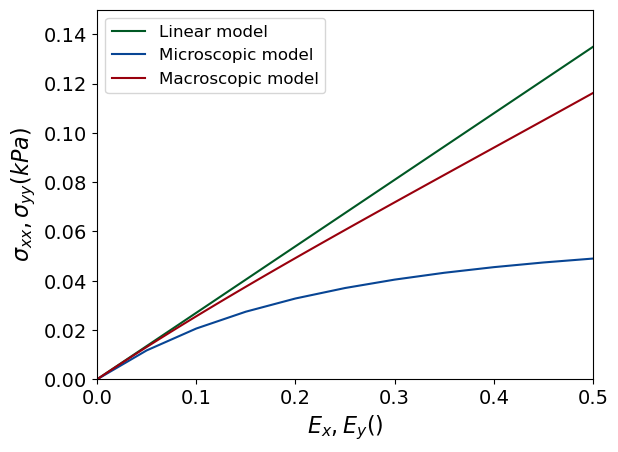

In [17]:
lam_lin = lambdify(epsilon, sigma_lin, modules=['numpy'])
lam_small = lambdify(epsilon, sigma_macro.subs(p, 0)[0,0], modules=['numpy'])

epsilon_vals = linspace(0, 1, 100)
sigma_small = lam_small(epsilon_vals)


sigma_vals_small = lam_small(epsilon_vals)
sigma_vals = lam_lin(epsilon_vals)


plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$E_x, E_y ()$', fontsize=16)
plt.ylabel(r'$\sigma_{xx}, \sigma_{yy} (kPa)$', fontsize=16)
plt.plot(epsilon_vals, sigma_vals, '#005824')
plt.plot(eps_glob_small, sigma_Eps_small, '#084594')
plt.plot(epsilon_vals, sigma_vals_small, '#99000D')
plt.legend(['Linear model', 'Microscopic model', 'Macroscopic model'])
plt.xlim(0, 0.5)
plt.ylim(0, 0.15)
# plt.savefig('Figures/macro-micro_small.pdf',bbox_inches='tight')
plt.show()

## sigma(p_f)

In [18]:
p_lst = []
sigma_xx_lst = []
sigma_bar = [[0., 0.],
             [0., 0.]]

for i in range(11):
    p_ = i/10
    p_lst.append(p_)
    sigma_xx_lst.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=0.0, eps_yy=0.0, pf=p_, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])

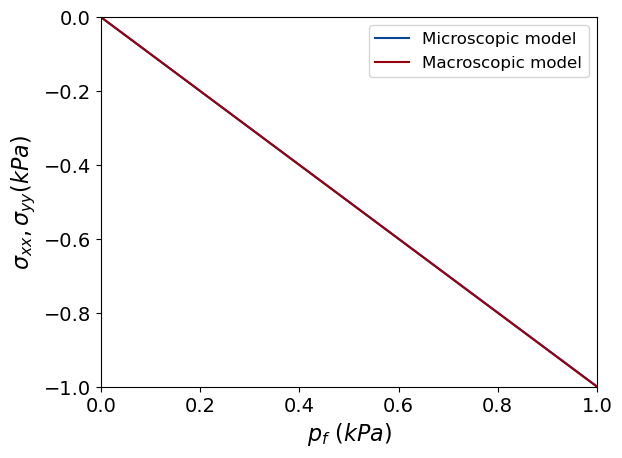

In [19]:
lam = lambdify(p, sigma_macro[0,0].subs(epsilon, 0), modules=['numpy'])
p_vals = linspace(0, 1, 100)
sigma_xx_lam = lam(p_vals)

plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(kPa)$', fontsize=16)
plt.ylabel(r'$\sigma_{xx}, \sigma_{yy} (kPa)$', fontsize=16)
plt.plot(p_lst, sigma_xx_lst, '#084594')
plt.plot(p_vals, sigma_xx_lam, '#99000D')
plt.legend(['Microscopic model', 'Macroscopic model'])
plt.xlim(0, 1)
plt.ylim(-1, 0)
# plt.savefig('pf_sigma_incompressible.pdf', bbox_inches='tight')  # bbox_inches='tight' saves the plot encadre '
plt.show()

### Compressible case

In [20]:
Es = 1
nus = 0.2
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}

Phi_s_lst_comp= []
p_lst = []
sigma_bar = [[0., 0.],
             [0., 0.]]
Macroscopic_strain = 0
for i in range(11):
    p_ = i/10
    p_lst.append(p_)
    Phi_s_lst_comp.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=0.0, eps_yy=0.0, pf=p_, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[4])

### Incompressible case

In [21]:
Es = 1
nus = 0.4999
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}

Phi_s_lst_incomp= []
p_lst = []
sigma_bar = [[0., 0.],
             [0., 0.]]
Macroscopic_strain = 0
for i in range(11):
    p_ = i/10
    p_lst.append(p_)
    Phi_s_lst_incomp.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=0.0, eps_yy=0.0, pf=p_, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[4])

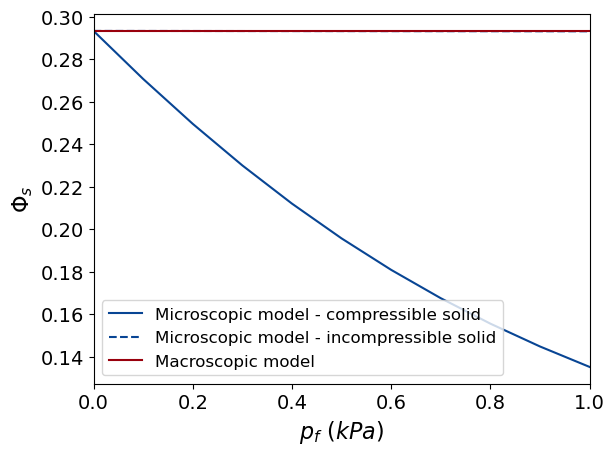

In [22]:
Phi_s_macro_lst = [Phi_s0]*len(p_lst)

plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(kPa)$', fontsize=16)
plt.ylabel(r'$\Phi_s$', fontsize=16)
plt.plot(p_lst, Phi_s_lst_comp, '#084594')
plt.plot(p_lst, Phi_s_lst_incomp, '#084594', linestyle='dashed')
plt.plot(p_lst, Phi_s_macro_lst, '#99000D')
plt.legend(['Microscopic model - compressible solid', 'Microscopic model - incompressible solid', 'Macroscopic model'])
plt.xlim(0, 1)
# plt.ylim(Phi_s0, Phi_s_lst_comp[-1])
# plt.savefig('Phi-s_p-f.pdf', bbox_inches='tight')  # bbox_inches='tight' saves the plot encadre '
plt.show()

## Phi_s(E)

### Incompressible

In [23]:
Es = 1
nus = 0.499
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}
Phi_s_lst_incomp = []
eps_lst = []

sigma_bar = [[0., 0.],
             [0., 0.]]

for i in range(11):
    eps_ = i/10
    eps_lst.append(eps_)
    Phi_s_lst_incomp.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps_, eps_yy=eps_, pf=0, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[4])

### Compressible

In [24]:
Es = 1
nus = 0.2
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}
Phi_s_lst_comp = []
eps_lst = []

sigma_bar = [[0., 0.],
             [0., 0.]]

for i in range(11):
    eps_ = i/10
    eps_lst.append(eps_)
    Phi_s_lst_comp.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps_, eps_yy=eps_, pf=0, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[4])

In [25]:
Phi_s0_lst = [Phi_s0]*len(eps_lst)

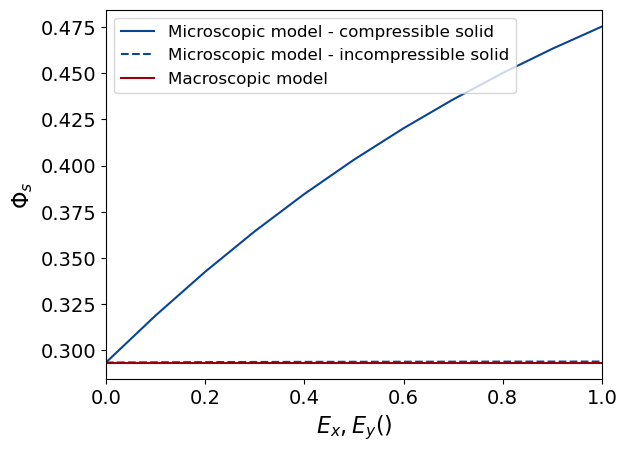

In [26]:
plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$E_x, E_y ()$', fontsize=16)
plt.ylabel(r'$\Phi_s$', fontsize=16)
plt.plot(eps_lst, Phi_s_lst_comp, '#084594')
plt.plot(eps_lst, Phi_s_lst_incomp, '#084594', linestyle='dashed')
plt.plot(eps_lst, Phi_s0_lst, '#99000D')
plt.legend(['Microscopic model - compressible solid', 'Microscopic model - incompressible solid', 'Macroscopic model'])
plt.xlim(0, 1)
# plt.ylim(Phi_s0, Phi_s_lst_comp[-1])
plt.savefig('Phi-s_E.pdf', bbox_inches='tight')  # bbox_inches='tight' saves the plot encadre '
plt.show()

### Color plate

In [ ]:
# %load '/Users/tayebi/Documents/Work/Ph.D./gnuplot-colorbrewer-master/sequential/Blues.plt'
# %load '/Users/tayebi/Documents/Work/Ph.D./gnuplot-colorbrewer-master/sequential/Reds.plt'
# %load '/Users/tayebi/Documents/Work/Ph.D./gnuplot-colorbrewer-master/sequential/BuGn.plt'
# %load '/Users/tayebi/Documents/Work/Ph.D./gnuplot-colorbrewer-master/qualitative/Paired.plt'


### Stress-strain comparision micro-Macro for differnent $E_s$

In [44]:
Es

1

In [45]:
nus

0.2

In [27]:
# Micromechanical model
sigma_glob_Es_1 = []
sigma_glob_Es_2 = []
sigma_glob_Es_3 = []

eps_glob = []

for i in range(11):
    eps = i/20
    eps_glob.append(eps)
    mat_params = {"model":"CGNH", "parameters":{"E":1, "nu":nus}}
    sigma_glob_Es_1.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])
    mat_params = {"model":"CGNH", "parameters":{"E":2, "nu":nus}}
    sigma_glob_Es_2.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])
    mat_params = {"model":"CGNH", "parameters":{"E":4, "nu":nus}}
    sigma_glob_Es_3.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])


# Poromechanical model
mat_params = {"model":"CGNH", "parameters":{"E":1, "nu":nus}}
sigma_macro_1 = macroscopic_model(mat_params)[0].subs(p, 0)
mat_params = {"model":"CGNH", "parameters":{"E":2, "nu":nus}}
sigma_macro_2 = macroscopic_model(mat_params)[0].subs(p, 0)
mat_params = {"model":"CGNH", "parameters":{"E":4, "nu":nus}}
sigma_macro_3 = macroscopic_model(mat_params)[0].subs(p, 0)


epsilon_vals = linspace(0, 0.5, 100)

lam = lambdify(epsilon, sigma_macro_1[0, 0], modules=['numpy'])
sigma_vals_1 = lam(epsilon_vals)

lam = lambdify(epsilon, sigma_macro_2[0, 0], modules=['numpy'])
sigma_vals_2 = lam(epsilon_vals)

lam = lambdify(epsilon, sigma_macro_3[0, 0], modules=['numpy'])
sigma_vals_3 = lam(epsilon_vals)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


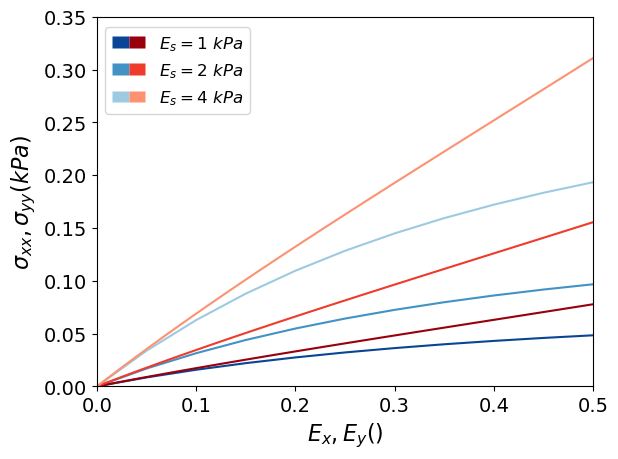

In [28]:
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch


# ------ choose some colors
colors1 = ['#084594', '#99000D']
colors2 = ['#4292C6', '#EF3B2C']
colors3 = ['#9ECAE1', '#FC9272']

# ------ create a dummy-plot (just to show that it works)
f, ax = plt.subplots()
ax.plot(eps_glob, sigma_glob_Es_1, c=colors1[0])
ax.plot(eps_glob, sigma_glob_Es_2, c=colors2[0])
ax.plot(eps_glob, sigma_glob_Es_3, c=colors3[0])
ax.plot(epsilon_vals, sigma_vals_1, c=colors1[1])
ax.plot(epsilon_vals, sigma_vals_2, c=colors2[1])
ax.plot(epsilon_vals, sigma_vals_3, c=colors3[1])

# ------ get the legend-entries that are already attached to the axis
h, l = ax.get_legend_handles_labels()

# ------ append the multicolor legend patches
h.append(MulticolorPatch(colors1))
l.append(r'$E_s = 1~kPa$')

h.append(MulticolorPatch(colors2))
l.append(r'$E_s = 2~kPa$')

h.append(MulticolorPatch(colors3))
l.append(r'$E_s = 4~kPa$')

# ------ create the legend
f.legend(h, l, loc='upper left', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(.125,.875))

plt.xlim(0, 0.5)
plt.ylim(0, 0.35)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$E_x, E_y ()$', fontsize=16)
plt.ylabel(r'$\sigma_{xx}, \sigma_{yy} (kPa)$', fontsize=16)
# plt.savefig('stress_strain_micro_macro_Es.pdf',bbox_inches='tight')
plt.show()

### Stress-strain comparision micro-Macro for differnent $\nu_s$

In [29]:
sigma_glob_nu_01 = []
sigma_glob_nu_02 = []
sigma_glob_nu_03 = []

eps_glob = []

for i in range(11):
    eps = i/20
    eps_glob.append(eps)
    mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":0.1}}
    sigma_glob_nu_01.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])
    mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":0.2}}
    sigma_glob_nu_02.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])
    mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":0.4}}
    sigma_glob_nu_03.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)[1])



In [30]:
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":0.1}}
sigma_macro_1 = macroscopic_model(mat_params)[0].subs(p, 0)
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":0.2}}
sigma_macro_2 = macroscopic_model(mat_params)[0].subs(p, 0)
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":0.4}}
sigma_macro_3 = macroscopic_model(mat_params)[0].subs(p, 0)

epsilon_vals = linspace(0, 0.5, 100)

lam = lambdify(epsilon, sigma_macro_1[0, 0], modules=['numpy'])
sigma_macro_1 = lam(epsilon_vals)

lam = lambdify(epsilon, sigma_macro_2[0, 0], modules=['numpy'])
sigma_macro_2 = lam(epsilon_vals)

lam = lambdify(epsilon, sigma_macro_3[0, 0], modules=['numpy'])
sigma_macro_3 = lam(epsilon_vals)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


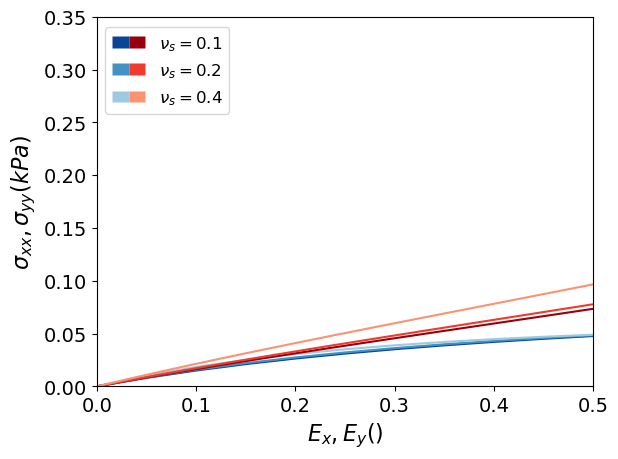

In [31]:
f, ax = plt.subplots()
ax.plot(eps_glob, sigma_glob_nu_01, c=colors1[0])
ax.plot(eps_glob, sigma_glob_nu_02, c=colors2[0])
ax.plot(eps_glob, sigma_glob_nu_03, c=colors3[0])
ax.plot(epsilon_vals, sigma_macro_1, c=colors1[1])
ax.plot(epsilon_vals, sigma_macro_2, c=colors2[1])
ax.plot(epsilon_vals, sigma_macro_3, c=colors3[1])

# ------ get the legend-entries that are already attached to the axis
h, l = ax.get_legend_handles_labels()

# ------ append the multicolor legend patches
h.append(MulticolorPatch(colors1))
l.append(r'$\nu_s = 0.1$')

h.append(MulticolorPatch(colors2))
l.append(r'$\nu_s = 0.2$')

h.append(MulticolorPatch(colors3))
l.append(r'$\nu_s = 0.4$')

# ------ create the legend
f.legend(h, l, loc='upper left', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(.125,.875))


plt.rc('legend', fontsize=12)
plt.xlabel(r'$E_x, E_y ()$', fontsize=16)
plt.ylabel(r'$\sigma_{xx}, \sigma_{yy} (kPa)$', fontsize=16)
plt.xlim(0, 0.5)
plt.ylim(0, 0.35)
# plt.savefig('stress_strain_micro_macro_nus.pdf',bbox_inches='tight')
plt.show()

# Terzaghi stress
## Incompressible

In [32]:
Es = 1
nus = 0.499
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}

Ex_00 = []
Ex_02 = []
Ex_04 = []
Ex_06 = []
Sigma_ter_p_00 = []
Sigma_ter_p_02 = []
Sigma_ter_p_04 = []
Sigma_ter_p_06 = []
Phi_s_p_00 = []
Phi_s_p_02 = []
Phi_s_p_04 = []
Phi_s_p_06 = []
eps_ter_lst = []

sigma_bar = [[0., 0.],
             [0., 0.]]

for i in range(19):
    eps = i/20
    eps_ter_lst.append(eps)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_00_, Phi_s_p_00_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_00.append(Sigma_ter_p_00_)
    Phi_s_p_00.append(Phi_s_p_00_)
    Ex_00.append(Ex_)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_02_, Phi_s_p_02_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0.25, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_02.append(Sigma_ter_p_02_)
    Phi_s_p_02.append(Phi_s_p_02_)
    Ex_02.append(Ex_)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_04_, Phi_s_p_04_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0.5, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_04.append(Sigma_ter_p_04_)
    Phi_s_p_04.append(Phi_s_p_04_)
    Ex_04.append(Ex_)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_06_, Phi_s_p_06_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=1, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_06.append(Sigma_ter_p_06_)
    Phi_s_p_06.append(Phi_s_p_06_)
    Ex_06.append(Ex_)

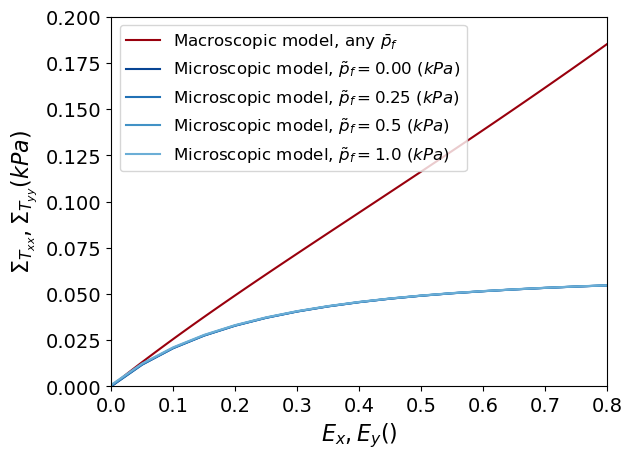

In [33]:
lam_lin = lambdify(epsilon, sigma_ter_macro[0,0], modules=['numpy'])

epsilon_ter_vals = linspace(0, 1, 100)
sigma_ter_vals = lam_lin(epsilon_ter_vals)

plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$E_x, E_y ()$', fontsize=16)
plt.ylabel(r'$\Sigma_{T_{xx}}, \Sigma_{T_{yy}} (kPa)$', fontsize=16)
plt.plot(epsilon_ter_vals, sigma_ter_vals, '#99000D')
plt.plot(Ex_00, Sigma_ter_p_00, '#084594')
plt.plot(Ex_02, Sigma_ter_p_02, '#2171B5')
plt.plot(Ex_04, Sigma_ter_p_04, '#4292C6')
plt.plot(Ex_06, Sigma_ter_p_06, '#6BAED6')
# plt.xlim(0, 1)
# plt.legend([r'$Micro, p_f=0.00~(kPa)$', r'$Micro, p_f=0.02~(kPa)$', r'$Micro, p_f=0.04~(kPa)$', r'$Micro, p_f=0.06~(kPa)$'])
plt.legend(['Macroscopic model, any'r'$~\bar{p}_f$', r'Microscopic model, $\tilde{p}_f=0.00~(kPa)$', r'Microscopic model, $\tilde{p}_f=0.25~(kPa)$', r'Microscopic model, $\tilde{p}_f=0.5~(kPa)$', r'Microscopic model, $\tilde{p}_f=1.0~(kPa)$'])
plt.xlim(0, 0.8)
plt.ylim(0, 0.2)
# plt.savefig('Stress_ter_strain_pressure_incompressible.pdf',bbox_inches='tight')
plt.show()

## Compressible

In [34]:
Es = 1
nus = 0.2
mat_params = {"model":"CGNH", "parameters":{"E":Es, "nu":nus}}

Ex_00 = []
Ex_02 = []
Ex_04 = []
Ex_06 = []
Sigma_ter_p_00 = []
Sigma_ter_p_02 = []
Sigma_ter_p_04 = []
Sigma_ter_p_06 = []
Phi_s_p_00 = []
Phi_s_p_02 = []
Phi_s_p_04 = []
Phi_s_p_06 = []
eps_ter_lst = []

sigma_bar = [[0., 0.],
             [0., 0.]]

for i in range(19):
    print(i)
    eps = i/20
    eps_ter_lst.append(eps)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_00_, Phi_s_p_00_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0., Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_00.append(Sigma_ter_p_00_)
    Phi_s_p_00.append(Phi_s_p_00_)
    Ex_00.append(Ex_)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_02_, Phi_s_p_02_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0.25, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_02.append(Sigma_ter_p_02_)
    Phi_s_p_02.append(Phi_s_p_02_)
    Ex_02.append(Ex_)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_04_, Phi_s_p_04_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=0.5, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_04.append(Sigma_ter_p_04_)
    Phi_s_p_04.append(Phi_s_p_04_)
    Ex_04.append(Ex_)
    [normalized_volume, sig_xx, sig_yy, Sigma_ter_p_06_, Phi_s_p_06_, Ex_, Ey_, Exy_] = global_response(mesh=mesh, mat_params=mat_params, eps_xx=eps, eps_yy=eps, pf=1, Macroscopic_strain=1, sigma_bar=sigma_bar, gamma=None)
    Sigma_ter_p_06.append(Sigma_ter_p_06_)
    Phi_s_p_06.append(Phi_s_p_06_)
    Ex_06.append(Ex_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


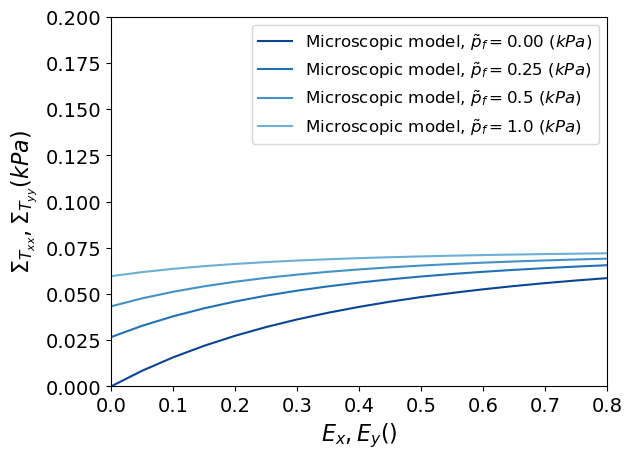

In [35]:
plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$E_x, E_y ()$', fontsize=16)
plt.ylabel(r'$\Sigma_{T_{xx}}, \Sigma_{T_{yy}} (kPa)$', fontsize=16)
plt.plot(Ex_00, Sigma_ter_p_00, '#084594')
plt.plot(Ex_02, Sigma_ter_p_02, '#2171B5')
plt.plot(Ex_04, Sigma_ter_p_04, '#4292C6')
plt.plot(Ex_06, Sigma_ter_p_06, '#6BAED6')
# plt.xlim(0, 1)
# plt.legend([r'$Micro, p_f=0.00~(kPa)$', r'$Micro, p_f=0.02~(kPa)$', r'$Micro, p_f=0.04~(kPa)$', r'$Micro, p_f=0.06~(kPa)$'])
plt.legend([r'Microscopic model, $\tilde{p}_f=0.00~(kPa)$', r'Microscopic model, $\tilde{p}_f=0.25~(kPa)$', r'Microscopic model, $\tilde{p}_f=0.5~(kPa)$', r'Microscopic model, $\tilde{p}_f=1.0~(kPa)$'])
plt.xlim(0, 0.8)
plt.ylim(0, 0.2)
# plt.savefig('Stress_ter_strain_pressure_compressible.pdf',bbox_inches='tight')
plt.show()